In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 读取数据集：no-filter数据、ground-truth数据集、运动控制U、测量集合Z
X_no_filter = np.load('./dataset/no_filter.npy')
X_ground_truth = np.load('./dataset/ground_truth.npy')
U = np.load('./dataset/u.npy')
Z = np.load('./dataset/z.npy')

# 无迹卡尔曼滤波

## 1. 无迹变换

无迹卡尔曼滤波通过无迹变换（Unscented Transform）来线性化。它不是通过泰勒级数展开去近似函数$g$，而是由UKF明确地从高斯中提取所谓的$\sigma$点，并将他们经过函数$g$进行变换。

通常情况下，这些$\sigma$点位于均值处及对称分布于主轴的协方差处（每维两个）。对于具有均值$\mu$和$\Sigma$的$n$维高斯分布，结果$2n+1$个$\sigma$点$\chi^{[i]}$根据如下规律进行选择：
$$\begin{align}
\chi^{[0]} &= \mu \\
\chi^{[i]} &= \mu + (\sqrt{(n + \lambda ) \Sigma})_i & i=1, \cdots , n \\
\chi^{[i]} &= \mu - (\sqrt{(n + \lambda ) \Sigma})_{i-n} & i=n+1, \cdots , 2n
\end{align}$$

式中，$\lambda = \alpha^2 (n + \kappa) - n$，$\alpha$和$\kappa$为确定$\sigma$点分布在均值多远范围内的比例参数。

每个$\sigma$点$\chi^{[i]}$有两个与之相关的权值。一个权值$\omega_m^{[i]}$，计算均值的时候使用。另一个权值$\omega_c^{[i]}$，计算高斯的协方差时使用。
$$\begin{align}
\omega_m^{[0]} &= \frac {\lambda}{n+ \lambda } \\
\omega_c^{[0]} &= \frac {\lambda}{n+ \lambda } + ( 1 - \alpha^2 + \beta ) \\
\omega_m^{[i]} &= \omega_c^{[i]} = \frac {1}{2(n+ \lambda )} \quad where \quad i = 1, \cdots , 2n \\
\end{align}$$

选择参数$\beta$对高斯表示的附加的（较高阶）分布信息进行编码。如果分布是精确的高斯分布，则$\beta = 2$是最佳选择。

$\sigma$点经过函数$g$变换，来探测$g$如何改变了高斯分布的形状。
$$y^{[i]} = g(\chi^{[i]})$$

结果高斯分布的参数$(\mu' , \Sigma')$由映射的$\sigma$点$y^{[i]}$获得：
$$\begin{align}
\mu' &= \sum_{i=0}^{2n} \omega_m^{[i]} y^{[i]} \\
\Sigma' &= \sum_{i=0}^{2n} \omega_c^{[i]} (y^{[i]} - \mu')(y^{[i]} - \mu')^T
\end{align}$$

## 2. 无迹卡尔曼滤波算法

----
01: **Algorithm Unscented_Kalman_filter**$( \mu_{t-1}, \Sigma_{t-1}, u_t, z_t )$**:**  

02: &emsp;&emsp;$\chi_{t-1} = ( \mu_{t-1} \quad \mu_{t-1} + \gamma \sqrt{\Sigma_{t-1}} \quad \mu_{t-1} - \gamma \sqrt{\Sigma_{t-1}})$  

03: &emsp;&emsp;$\bar{\chi}_t^* = g(\mu_t, \chi_{t-1})$  

04: &emsp;&emsp;$\bar{\mu}_t = \sum_{i=0}^{2n} \omega_m^{[i]} \bar{\chi}_t^{*[i]}$  

05: &emsp;&emsp;$\bar{\Sigma}_t = \sum_{i=0}^{2n} \omega_c^{[i]} (\bar{\chi}_t^{*[i]} - \bar{\mu}_t)(\bar{\chi}_t^{*[i]} - \bar{\mu}_t)^T + R_t$  

06: &emsp;&emsp;$\bar{\chi}_t = ( \bar{\mu}_t \quad \bar{\mu}_t + \gamma \sqrt{\bar{\Sigma}_t} \quad \bar{\mu}_t - \gamma \sqrt{\bar{\Sigma}_t})$  

07: &emsp;&emsp;$\bar Z_t = h(\bar{\chi}_t)$  

08: &emsp;&emsp;$\widehat{z}_t = \sum_{i=0}^{2n} \omega_m^{[i]} \bar Z_t^{[i]}$  

09: &emsp;&emsp;$S_t = \sum_{i=0}^{2n} \omega_c^{[i]} (\bar Z_t^{[i]} - \widehat z_t) (\bar Z_t^{[i]} - \widehat z_t)^T + Q_t$  

10: &emsp;&emsp;$\bar{\Sigma}_t^{x,z} = \sum_{i=0}^{2n} \omega_c^{[i]} (\bar {\chi}_t^{[i]} - \bar {\mu}_t)(\bar {Z}_t^{[i]} - \widehat {z}_t)^T$  

11: &emsp;&emsp;$K_t = \bar {\Sigma}_t^{x,z} S_t^{-1}$  

12: &emsp;&emsp;$\mu_t = \bar {\mu}_t + K_t (z_t - \widehat z_t)$  

13: &emsp;&emsp;$\Sigma_t = \bar {\Sigma}_t - K_t S_t K_t^T$  

14: &emsp;&emsp;**return**$\quad \mu_t , \Sigma_t$  

----

In [3]:
# 设定UKF的超参数

# 状态Xt的维度
n_ukf = 3

# alpha和kappa为确定sigma点分布在均值多远范围内的的比例参数
alpha_ukf = 0.01
kappa_ukf = 3 - n_ukf

# 计算有alpha和kappa确定的超参数lambda_ukf
lambda_ukf = alpha_ukf ** 2 * (n_ukf + kappa_ukf) - n_ukf

# 根据lambda的值计算gamma的值
gamma_ukf = np.sqrt(n_ukf + lambda_ukf)

# 超参数beta参与生成协方差的系数，对高斯表示的附加的（高阶）信息进行编码。
# 如果分布是精确地高斯分布，则beta=2是较好的选择
beta_ukf = 2.0

lambda_ukf

-2.9997

In [4]:
# 生成均值与协方差系数
# 涉及UKF算法的第4/5/8/9/10行
def weight_sigmaPoint_ukf():
    weight = 0.5 / (n_ukf + lambda_ukf)
    weight_mean = np.ones(1 + n_ukf * 2) * weight
    weight_cov  = np.ones(1 + n_ukf * 2) * weight
    weight_mean[0] = lambda_ukf / (lambda_ukf + n_ukf)
    weight_cov[0]  = lambda_ukf / (lambda_ukf + n_ukf) + (1 - alpha_ukf ** 2 + beta_ukf)
#     weight_mean[0] = 0
#     weight_cov[0] = 0
    return weight_mean.reshape((-1,1)), weight_cov.reshape((-1,1))

# test code
weight_sigmaPoint_ukf()

(array([[-9998.99999999],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667]]), array([[-9996.00009999],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667],
        [ 1666.66666667]]))

In [5]:
# 通过均值mu和协方差矩阵Sigma产生sigma点集，点集以(n_ukf * 2 + 1) by 3的矩阵形式返回
# 涉及UKF算法的第2/6行
def generate_sigma_points(mu, sigma):
    # 将mu的形状重新调整为向量
    mu = np.squeeze(mu).reshape((1,3))
    
    # 计算sigma矩阵的平方根
    try:
        sqrt_sigma = np.linalg.cholesky(sigma)
    except:
        e, v = np.linalg.eig(sigma)
        e = e - np.min(e) + 0.1
        sqrt_sigma = np.dot(v, np.diag(np.sqrt(e)))
        
    
    # 为了便于计算，根据返回矩阵的格式，将sigma矩阵平方根进行转置
    sqrt_sigma = sqrt_sigma.T
    
    # 生成正方向的sigma点
    positive_sigma_points = mu + gamma_ukf * sqrt_sigma
    negative_sigma_points = mu - gamma_ukf * sqrt_sigma
    
    sigma_points = np.vstack([mu , positive_sigma_points, negative_sigma_points])
    
    return sigma_points

# test code
m = np.array([2, 1, .5, 1,3,0.7,.5,0.7,5]).reshape((3, 3))
generate_sigma_points(np.array([0, 0, np.pi/4]), m)

array([[ 0.        ,  0.        ,  0.78539816],
       [ 0.0244949 ,  0.01224745,  0.79152189],
       [ 0.        ,  0.02738613,  0.79032767],
       [ 0.        ,  0.        ,  0.82332177],
       [-0.0244949 , -0.01224745,  0.77927444],
       [ 0.        , -0.02738613,  0.78046866],
       [ 0.        ,  0.        ,  0.74747456]])

运动模型：

假设机器人的运动控制是向前移动$u_t$个单位，因此移动后机器人的期望位置将为：
$$\begin{bmatrix}
x' \\ y' \\ \theta'
\end{bmatrix} = \begin{bmatrix}
x + u_t cos \theta \\ y + u_t sin \theta \\ \theta
\end{bmatrix}$$

In [6]:
# 运动迁移方程的向量化版本
# 涉及UKF算法的第3行
def motion_model(sigma_points, u):
    xs = sigma_points[:,0].reshape((-1,1))
    ys = sigma_points[:,1].reshape((-1,1))
    thetas = sigma_points[:,2].reshape((-1,1))
    
    xs_motion = xs + u * np.cos(thetas)
    ys_motion = ys + u * np.sin(thetas)
    thetas_motion = thetas
    
    sigma_points_motion = np.hstack([xs_motion, ys_motion, thetas_motion])
    return sigma_points_motion

# test code
motion_model(generate_sigma_points(np.array([0, 0, np.pi/4]), m),2)

array([[ 1.41421356,  1.41421356,  0.78539816],
       [ 1.43002174,  1.43509469,  0.79152189],
       [ 1.40722504,  1.44855385,  0.79032767],
       [ 1.3595775 ,  1.46681595,  0.82332177],
       [ 1.39835235,  1.3932794 ,  0.77927444],
       [ 1.42116772,  1.37983891,  0.78046866],
       [ 1.46681595,  1.3595775 ,  0.74747456]])

测量模型：
$$h(\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}) = 
\begin{bmatrix} z_{distance} \\ z_{\theta} \end{bmatrix} = 
\begin{bmatrix} \sqrt{x^2 + y^2} \\ \theta \end{bmatrix} $$

In [7]:
# 测量模型的向量化版本
# 涉及UKF算法的第7行
def measurement_model(sigma_points):
    xs = sigma_points[:,0].reshape((-1,1))
    ys = sigma_points[:,1].reshape((-1,1))
    thetas = sigma_points[:,2].reshape((-1,1))
    
    z_distance = np.sqrt(xs ** 2 + ys ** 2)
    z_theta = thetas
    
    sigma_points_measurement = np.hstack([z_distance, z_theta])
    return sigma_points_measurement
    
measurement_model(generate_sigma_points(np.array([0, 0, np.pi/4]), m))

array([[ 0.        ,  0.78539816],
       [ 0.02738613,  0.79152189],
       [ 0.02738613,  0.79032767],
       [ 0.        ,  0.82332177],
       [ 0.02738613,  0.77927444],
       [ 0.02738613,  0.78046866],
       [ 0.        ,  0.74747456]])

In [8]:
# 定义UKF算法
def unscented_kalman_filter(mu, Sigma, u, z):
    # 计算sigma点的系数
    weight_m, weight_c = weight_sigmaPoint_ukf()
    
    # line 2
    sigma_points_original = generate_sigma_points(mu, Sigma)
    
    # line 3
    sigma_points_motion_model = motion_model(sigma_points_original, u)
    
    # line 4
    mu_after_motion = np.sum(weight_m * sigma_points_motion_model, axis=0, keepdims=True).T
    
    # line 5
    R = np.diag(np.zeros(3) * 10)
    temp = sigma_points_motion_model - mu_after_motion.T
    Sigma_after_motion = np.dot((weight_c * temp).T, temp) + R
    
    # line 6
    sigma_points_before_measure = generate_sigma_points(mu_after_motion,
                                                      Sigma_after_motion)
    
    # line 7
    z_sigma_points_after_measure = measurement_model(sigma_points_before_measure)
    
    # line 8
    z_hat = np.sum(weight_m * z_sigma_points_after_measure, axis=0, keepdims=True).T
    
    # line 9
    Q = np.diag(np.ones(2) * 5)
    temp = z_sigma_points_after_measure - z_hat.T
    S = np.dot((weight_c * temp).T, temp) + Q
    
    # line 10
    temp1 = sigma_points_before_measure - mu_after_motion.T
    temp2 = z_sigma_points_after_measure - z_hat.T
    Sigma_x_z = np.dot((weight_c * temp1).T, temp2)
    
    # line 11
    K = np.dot(Sigma_x_z, np.linalg.inv(S))
    
    # line 12
    mu_after_measure = mu_after_motion + np.dot(K, z - z_hat)
    
    # line 13
    Sigma_after_measure = Sigma_after_motion + np.dot(np.dot(K, S), K.T)
    
    return mu_after_measure, Sigma_after_measure

unscented_kalman_filter(np.array([0,0,np.pi/4]).reshape((-1,1)), np.diag([0.01, 0.01, 0.01]),
                        U[0], Z[0])

(array([[ 0.79786261],
        [ 0.79874351],
        [ 0.78594691]]), array([[ 0.01649764, -0.00641299, -0.00804251],
        [-0.00641299,  0.01649764,  0.00804251],
        [-0.00804251,  0.00804251,  0.01001996]]))

In [9]:
Sigma_ukf = []
# 设定初始的位姿和初始的协方差
X_ukf = np.array([0, 0, np.pi / 4]).reshape((1,3))
sigma = np.diag([ .01, .01, 0.01])
Sigma_ukf.append(sigma)
n = 100
for u, z in zip(U[:n], Z[:n]):
    mu, sigma = unscented_kalman_filter(X_ukf[-1], Sigma_ukf[-1], u, z);
    X_ukf = np.vstack([X_ukf, mu.T])
    Sigma_ukf.append(sigma)

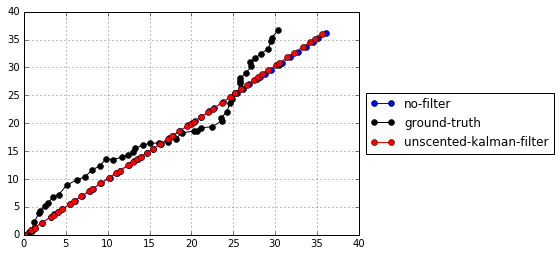

In [10]:
n = 50
fig, ax = plt.subplots()
ax.plot(X_no_filter[:n,0], X_no_filter[:n,1], 
        c='b',marker='o', label='no-filter')
ax.plot(X_ground_truth[:n,0], X_ground_truth[:n,1], 
        c='k',marker='o', label='ground-truth')
ax.plot(X_ukf[:n,0], X_ukf[:n,1], 
        c='r',marker='o', label='unscented-kalman-filter')
ax.legend(bbox_to_anchor=(1.6, 0.5), loc='center right')
ax.grid()

In [11]:
X_ukf.shape

(101, 3)

UKF滤波目前存在的问题：
1. 超参数的调整
2. 协方差矩阵因为没有收敛，导致最终无法保证是正定矩阵，因此矩阵分解失败。
3. 采用特征值分解，对特征值进行调整对协方差进行调整，以保证可以对协方差矩阵进行分解。
4. 需要调整$R_t$和$Q_t$以保证不会发散。